# Lecture 12 - Intro to ML

### Learning Objectives

After this class, students will be able to
- identify the key elements of a supervised ML system: data, model, parameters, loss function, training loop
- define "training" in ML
- prompt an LLM to generate pytorch ML code
- explain what under- and over-fitting are, and the need for train/test splits


In [1]:
# I'm running today's lecture on a GPU server
# This line chooses which GPU I'll be running on. Run this line before any other imports. 
# To change GPUs, restart your kernel and then rerun this cell.
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # Use this GPU

### Approach today: zero to ML, a step at a time
Many of you have seen ML fundamentals in other classes. You'll know many of the things we're doing today already. We'll begin by designing systems with serious flaws, and we'll fix them as we discover them. Please play along with the story, and don't drop spoilers too soon.

### Approach today: LLMs
We're going to try LLM-assisted coding in class today. I have two goals on this:

- Demoing how to use AI to assist in developing ML systems
- Keeping today's emphasis on ML ideas, rather than on code syntax

## Plan for today:

- [ ] Get a dataset - CIFAR10. Explore and visualize.
- [ ] Create "Dataloaders"
- [ ] Prompt an LLM to get a simple model
- [ ] Prompt an LLM to learn about our options for loss functions
- [ ] Prompt an LLM to get a simple training loop
- [ ] Train our model
- [ ] Evaluate the performance


#### Our Dataset: [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html)
Why?

- it's a vision dataset
- the vision problem (image classification) is relatively straightforward
- it's small enough we can do training runs live in class

pyTorch comes with several built-in datasets, ranging from quite small to very large. Let's use pytorch to load this dataset next.

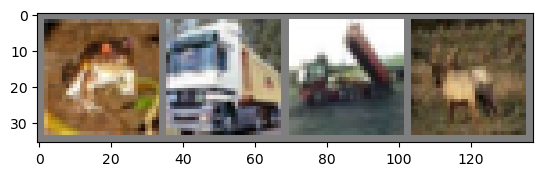

frog  truck truck deer 
Type of images: <class 'torch.Tensor'>
Shape of images batch: torch.Size([4, 3, 32, 32])
Shape of a single image: torch.Size([3, 32, 32])
Data type of images: torch.float32
Type of labels: <class 'list'>
Shape of labels: 4
Data type of labels: <class 'int'>


In [12]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Transformations to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

classes = trainset.classes

# Function to show an image
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get a few random training images
images, labels = [], []
for i in range(4):
    image, label = trainset[i]
    images.append(image)
    labels.append(label)

# Convert list of tensors to a single tensor
images = torch.stack(images)

# Show images
imshow(torchvision.utils.make_grid(images))
# Print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

# Exploratory data analysis
print(f'Type of images: {type(images)}')
print(f'Shape of images batch: {images.shape}')
print(f'Shape of a single image: {images[0].shape}')
print(f'Data type of images: {images.dtype}')

print(f'Type of labels: {type(labels)}')
print(f'Shape of labels: {len(labels)}')
print(f'Data type of labels: {type(labels[0])}')

In [13]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Second convolutional layer
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        # Fully connected layers
        self.fc1 = nn.Linear(in_features=64 * 8 * 8, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=10)

    def forward(self, x):
        # First convolutional layer with ReLU and pooling
        x = self.pool(F.relu(self.conv1(x)))
        # Second convolutional layer with ReLU and pooling
        x = self.pool(F.relu(self.conv2(x)))
        # Flatten the feature maps
        x = x.view(-1, 64 * 8 * 8)
        # First fully connected layer with ReLU
        x = F.relu(self.fc1(x))
        # Second fully connected layer for output
        x = self.fc2(x)
        return x

# Instantiate the model
model = SimpleCNN()
print(model)

SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=4096, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)


In [14]:
import torch.optim as optim

# Hyperparameters
learning_rate = 0.001
num_epochs = 10
batch_size = 60

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleCNN().to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(trainloader, 0):
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if i % 100 == 99:  # print every 100 mini-batches
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(trainloader)}], Loss: {running_loss / 100:.4f}')
            running_loss = 0.0

print('Finished Training')

Epoch [1/10], Step [100/12500], Loss: 2.2243
Epoch [1/10], Step [200/12500], Loss: 2.0970
Epoch [1/10], Step [300/12500], Loss: 1.9562
Epoch [1/10], Step [400/12500], Loss: 1.8711
Epoch [1/10], Step [500/12500], Loss: 1.8451
Epoch [1/10], Step [600/12500], Loss: 1.8271
Epoch [1/10], Step [700/12500], Loss: 1.7742
Epoch [1/10], Step [800/12500], Loss: 1.6216
Epoch [1/10], Step [900/12500], Loss: 1.7015
Epoch [1/10], Step [1000/12500], Loss: 1.6142
Epoch [1/10], Step [1100/12500], Loss: 1.6565
Epoch [1/10], Step [1200/12500], Loss: 1.5276
Epoch [1/10], Step [1300/12500], Loss: 1.5768
Epoch [1/10], Step [1400/12500], Loss: 1.5898
Epoch [1/10], Step [1500/12500], Loss: 1.4917
Epoch [1/10], Step [1600/12500], Loss: 1.5352
Epoch [1/10], Step [1700/12500], Loss: 1.4259
Epoch [1/10], Step [1800/12500], Loss: 1.3659
Epoch [1/10], Step [1900/12500], Loss: 1.5818
Epoch [1/10], Step [2000/12500], Loss: 1.2877
Epoch [1/10], Step [2100/12500], Loss: 1.4920
Epoch [1/10], Step [2200/12500], Loss: 1.42

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load datasets
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# DataLoaders
trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

# Define the model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Function to compute accuracy
def compute_accuracy(loader, model, device):
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total
    
# Initialize model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training and validation
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    train_bar = tqdm(trainloader, desc=f"Epoch {epoch+1}/{num_epochs} Train", leave=False)
    
    for inputs, labels in train_bar:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        train_bar.set_postfix(loss=running_loss / (train_bar.n + 1))
        
    # Compute training accuracy
    train_accuracy = compute_accuracy(trainloader, model, device)
    
    # Validation
    model.eval()
    test_accuracy = compute_accuracy(testloader, model, device)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(trainloader):.4f}, '
          f'Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%')

print('Finished Training')

Epoch 1/10, Loss: 1.2941, Train Accuracy: 65.07%, Test Accuracy: 62.99%


Epoch 2/10, Loss: 0.8965, Train Accuracy: 75.38%, Test Accuracy: 69.34%


Epoch 3/10, Loss: 0.6948, Train Accuracy: 82.22%, Test Accuracy: 72.65%


Epoch 4/10, Loss: 0.5328, Train Accuracy: 88.48%, Test Accuracy: 74.11%


Epoch 5/10, Loss: 0.3798, Train Accuracy: 92.95%, Test Accuracy: 73.10%


Epoch 6/10, Loss: 0.2455, Train Accuracy: 94.78%, Test Accuracy: 72.77%


Epoch 7/10, Loss: 0.1529, Train Accuracy: 97.20%, Test Accuracy: 72.93%


Epoch 8/10, Loss: 0.1011, Train Accuracy: 97.91%, Test Accuracy: 72.45%


Epoch 9/10, Loss: 0.0791, Train Accuracy: 97.90%, Test Accuracy: 71.34%


Epoch 10/10, Loss: 0.0657, Train Accuracy: 98.58%, Test Accuracy: 72.31%
Finished Training


#### Summary: What does it mean to train a model?

A model is a programmatically-defined function whose outputs depend on two things:

- An input (think, an image to process)
- Parameters (the coefficients in the huge list of equations that a model uses internally to process data)

Training is optimization: we're searching for a special set of parameters that cause the model to mostly give the right answers for most inputs.

<div>
<img src="https://imgs.xkcd.com/comics/machine_learning_2x.png" width="360"/>
</div>

Link: [xkcd 1838](https://xkcd.com/1838)

#### Summary: Elements of Training in PyTorch

We used an LLM to generate most of this code. Any working solution should have all of these pieces:

- Dealing with data:
  - `torch.utils.data.Dataset` : a list of data and labels
  - `torch.utils.data.random_split` : a function that randomly splits your data into train and test sets, if your dataset doesn't come with a split given to you
  - `torch.utils.data.DataLoader` : a wrapper around a `Dataset` that generates random "batches" as needed
- Setting up a model:
  - `torch.nn.Module` : code that says how your model processes input and creates output
- A "training loop" that does model training. (outer loop: epochs. inner loop: batches.)
  - `torch.nn.Loss` : a small function that decides how far the model's output is from the right answer
  - `torch.nn.Optimizer` : a choice of an algorithm that searches for a set of Parameters that work

**Vocab**: an *epoch* is one pass through the training dataset. A model that has been trained for one epoch has seen each image in the training dataset exactly once.